Import the necessary libraries

In [1]:
import torch as torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import os as os
import numpy as np
import pandas as pd
import csv as csv
from sklearn.model_selection import train_test_split
from PIL import Image as PilImage
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from torch.utils.data import  random_split
from torch.nn.functional import log_softmax
from datetime import datetime
from torch.nn.functional import cross_entropy

/Users/darylramdin/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is the dataset for loading the weather data. It inherits from the 
pytorch dataset

In [2]:
class WeatherDataset(Dataset):
    def __init__(self,annotations_file, image_dir, transform=None):
        '''

        :param annotations_file: The name of the file in the image_dir that stores the annotations
                                 The file has the following format index,label,weather,imgfile
                                 index: index of the image
                                 label: the encoded label
                                 weather: the friendly text name of the weather. This is a subfolder in image_dir
                                 imgfile: the name of the file
        :param image_dir: The directory that stores the images
        :param transform: Holds any transforms that are to be applied to the data
        '''
        #Get the labels, image directory and transforms
        self.image_labels = pd.read_csv(image_dir+"/"+annotations_file)
        self.image_dir = image_dir
        self.transform = transform

    #Returns the length of the dataset
    def __len__(self):
        return len(self.image_labels)

    #Get the item at the given index
    def __getitem__(self, index):
        #Get the encoded value of the label
        label = self.image_labels.iloc[index,1]

        #Get the type of weather. This is a subfolder
        weather_type = self.image_labels.iloc[index,2]

        #Get the name of the image file at the given index
        imgfile = self.image_labels.iloc[index, 3]

        #Build the filepath
        filepath = self.image_dir + "/" + weather_type + "/" + imgfile

        '''
        Open the image and convert to RGB. This ensures we have 3 channels
        as some files contained 4 channels
        '''
        image = PilImage.open(filepath).convert("RGB")

        #If any transforms were supplied, apply them
        if self.transform is not None:
            image = self.transform(image)

        #Conver the label to a tensor
        label = torch.tensor(label)

        #Return the image and label tensors
        return image,label



This is our Convolution Neural Network class.

In [3]:
class WeatherCNN(nn.Module):
    def __init__(self, layer_count):
        self.layer_count = layer_count
        super().__init__()


        # This is our first convolution layer. The numnber of input channels
        # must be set to 3 which is the number of channels in our images
        self.conv_unit_1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        if layer_count == 2:
            # This is the second convolution layer. At the end of this layer
            # we flatten the data so that it can be fed into our fully connected layers
            self.conv_unit_2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Flatten()
            )

            # Fully connected layers
            #self.fc1 = nn.Linear(32768, 128)
            self.fc1 = nn.Linear(65536, 128)
            self.fc2 = nn.Linear(128, 11)
        else:
            # This is the second convolution layer. At the end of this layer
            # we flatten the data so that it can be fed into our fully connected layers
            self.conv_unit_2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )

            # This is the third convolution layer. At the end of this layer
            # we flatten the data so that it can be fed into our fully connected layers
            self.conv_unit_3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Flatten()
            )

            # Fully connected layers
            self.fc1 = nn.Linear(32768, 128)
            # self.fc1 = nn.Linear(65536, 128)
            self.fc2 = nn.Linear(128, 11)

    #This is called for the forward propagation of the model
    def forward(self, x):
        out = self.conv_unit_1(x)
        out = self.conv_unit_2(out)
        if(self.layer_count==3):
            out = self.conv_unit_3(out)
        out = self.fc1(out)
        out = self.fc2(out)
        # Apply softmax
        out = log_softmax(out,dim=1)
        return out


This is a helper function to create the annocation file.
Each subfolder in the weather folder contains images for a given type of weather.
There are 11 types of weather. The function iterates through each folder, and assigns
an index to each file. Indexes continue from the previous folder.

In [4]:
def create_annotations():
    #Our main weather folder is under the data dicrectory in this projecy
    img_directory = "../data/weather"
    #Create the csv file and write the header row
    f = open(img_directory+"/weather_annotations.csv","w")
    fwrite = csv.writer(f)
    row = ['index', 'label', 'fld', 'imgfile']
    fwrite.writerow(row)
    #Initialise our label and index counters
    label = 0
    index = 0
    # Iterate through each subfolder and assigned indices to our files
    # For each new subfolder, we increment our label counter
    for fld in os.listdir(img_directory):
        fpath = img_directory+"/"+fld
        if os.path.isfile(fpath) == False:
            #This is a folder for a class of weather. Get the label code
            for imgfile in os.listdir(fpath):
                row = [index,label,fld,imgfile]
                # Write the image info to the annotation file
                fwrite.writerow(row)
                index += 1
            label += 1
    f.close()

This function allows us to see a subset of the images.
Code Reference: INM702 2022, LAB09_4
https://moodle.city.ac.uk/pluginfile.php/2994042/mod_folder/content/0/Lab09_4.ipynb?forcedownload=1

In [5]:
def preview_images(preview_dl):
    """Plot images grid of single batch"""
    for batch in preview_dl:
        images, labels = batch
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=5).permute(1, 2, 0)) #Convert channelxWxH to WxHxchannel
        plt.show()
        break

This function helps to calculate the accuracy
Code Reference: INM702 2022, LAB09_4

In [6]:
def get_accuracy(outputs, labels):
    #As we are using softmax, get the column with the largest value. This
    #will correspond to the prediction
    values, indices = torch.max(outputs, dim=1)

    #Get the total number of rows that match and divide by the number of
    #indices to give an average accuracy
    return torch.tensor(torch.sum(indices == labels).item() / len(indices))

This function helps to calculate the accuracy of the prediction
Code Reference: INM702 2022, LAB09_4

In [7]:
@torch.no_grad()
def predict(model, d_loader):
    model.eval()
    losses = []
    accuracies = []
    for batch in d_loader:
        images, labels = batch
        output = model(images)
        accuracy = get_accuracy(output, labels)
        loss = cross_entropy(output, labels)
        accuracies.append(accuracy)
        losses.append(loss)
    loss = torch.stack(losses).mean().item()
    accuracy = torch.stack(accuracies).mean().item()*100
    return loss,accuracy

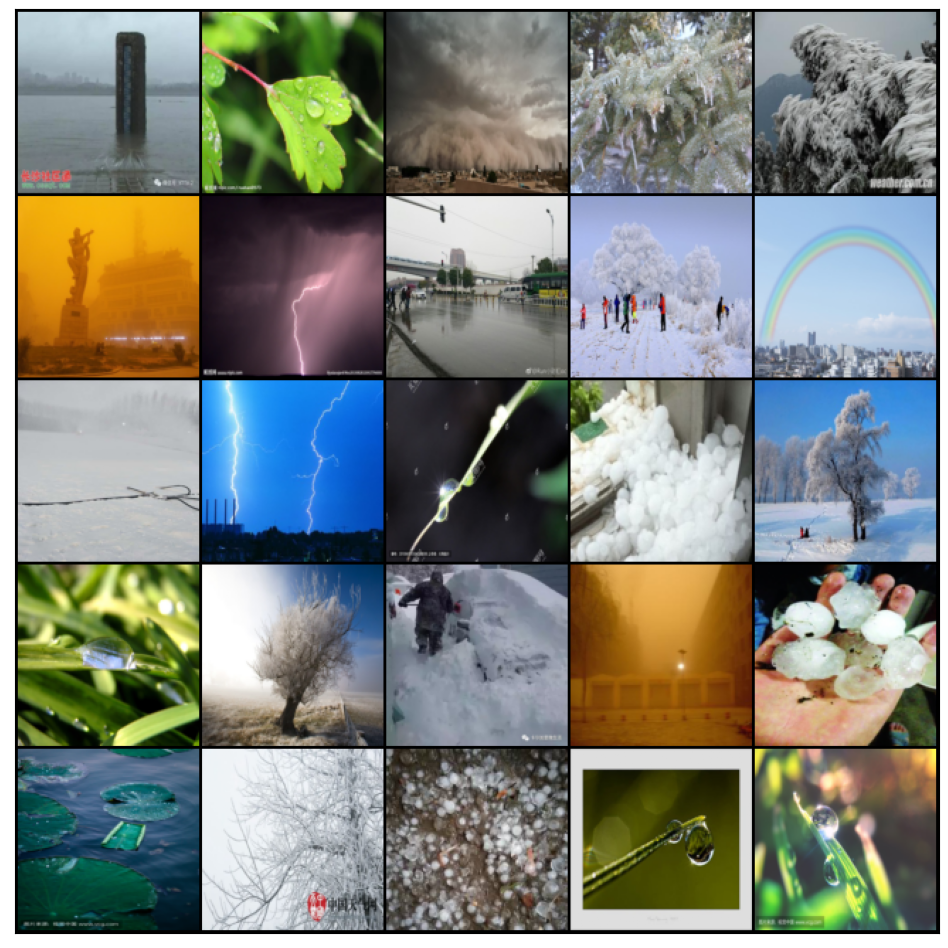

In [8]:
data_dir = "../data/weather"

'''
Let's create the WeatherDataset. The following transforms are applied
1) Resize the images to 128*128 pixels
2) Convert them to a Tensor
'''
transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
#Create the dataset
weather_ds = WeatherDataset("weather_annotations.csv","../data/weather",transform)

#Let's preview some of the data. We'll use a data loader for it
preview_loader = DataLoader(weather_ds,25, shuffle=True)
preview_images(preview_loader)



In [ ]:
#Let's train the CNN

#Create the CNN
model = WeatherCNN(3)

#Model Definition
print("Definition:",model)


#We next split our dataset into training and test datasets
train_dataset, test_dataset = random_split(weather_ds, [0.8, 0.2])

# Create our data loader for getting the training images
train_loader = DataLoader(train_dataset, 128, shuffle = True)
test_loader =  DataLoader(test_dataset, 128, shuffle = True)

#Set the number of epochs
epochs = 10

#Set our learning rate
learning_rate = 0.01

#We use Adam as our optimizer
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

master_metrics_log = np.empty((0, 4), float)


for epoch in range(epochs):
    print("Epoch:", epoch)
    start = datetime.now()
    model.train()
    train_losses = []
    for batch in train_loader:
        images, labels = batch
        #Forward pass
        out = model(images)
        #Calculate the loss and accuracy
        loss = cross_entropy(out, labels)   # Calculate loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    #Let's see how our model is performing on the test data set
    loss,accuracy = predict(model, test_loader)
    # After each epoch print Loss and Accuracy
    print("Epoch", epoch, "Loss:", loss, "Accuracy: ", accuracy, "Duration:", datetime.now() - start)
    master_metrics_log = np.append(master_metrics_log, np.array([["Adam", epoch, loss, accuracy]]), 0)



Definition: WeatherCNN(
  (conv_unit_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_unit_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_unit_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)
Epoch: 0
Epoch 0 Loss: 1.9136021137237549 Accuracy:  35.98690629005432 Duration: 0:01:16.133896
Epoch: 1
